In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
import os.path as osp

In [3]:
with open('../paper_analysis_notebooks/OUTPUT_DIR.txt','r+') as f:
    OUTPUT_ROOT = f.readlines()[0]

OUTPUT_DIR = osp.join(OUTPUT_ROOT, 'coculture')

In [4]:
!ls $OUTPUT_DIR

beta_DC_vs_Tcell_CD4+.csv  hvg_DC.csv
beta_Tcell_CD4+_vs_DC.csv  inter_res.netcdf


In [413]:
pred_ig = pd.read_csv(osp.join(OUTPUT_DIR,'beta_DC_vs_Tcell_CD4+.csv'),header = 0, index_col =0)
pred_hvg = pd.read_csv(osp.join(OUTPUT_DIR,'hvg_DC.csv'), header = 0, index_col =0)

In [414]:
true = pd.read_csv('../data/imod/cell_culture_data/de_lists/DC_scanpy.csv', header =0, index_col = 0)

In [415]:
true.index = [x.lower() for x in true['names'] ]

In [416]:
inter = pred_ig.index.intersection(pred_hvg.index).intersection(true.index)

In [417]:
pred_ig = pred_ig.loc[inter][['beta']]
pred_ig.columns = ['score']
pred_ig['feature'] = pred_ig.index
pred_hvg = pred_hvg.loc[inter][['score','feature']]
true = true.loc[inter]

In [418]:
alpha_sig = 0.05
true = true.iloc[true.pvals_adj.values <= alpha_sig]
true = true[true.logfoldchanges.values > 0.]

In [419]:
true = true['logfoldchanges']

In [420]:
import telegraph as tg
import numpy as np

In [421]:
true_ig = np.array([float(x in true.index) for x in pred_ig.index])
true_hvg = np.array([float(x in true.index) for x in pred_hvg.index])

In [422]:
pr_curve_ig = precision_recall_curve(true_ig, pred_ig['score'].values,)
pr_curve_hvg = precision_recall_curve(true_ig, pred_hvg['score'].values)

In [424]:
score_ig = roc_curve(true_ig, pred_ig['score'].values)
score_hvg  =roc_curve(true_hvg, pred_hvg['score'].values)

In [457]:
auroc_ig =  roc_auc_score(true_ig, pred_ig['score'].values)
auroc_hvg  = roc_auc_score(true_hvg, pred_hvg['score'].values)

In [458]:
auroc_ig,auroc_hvg

(0.7433495586416711, 0.631056994447216)

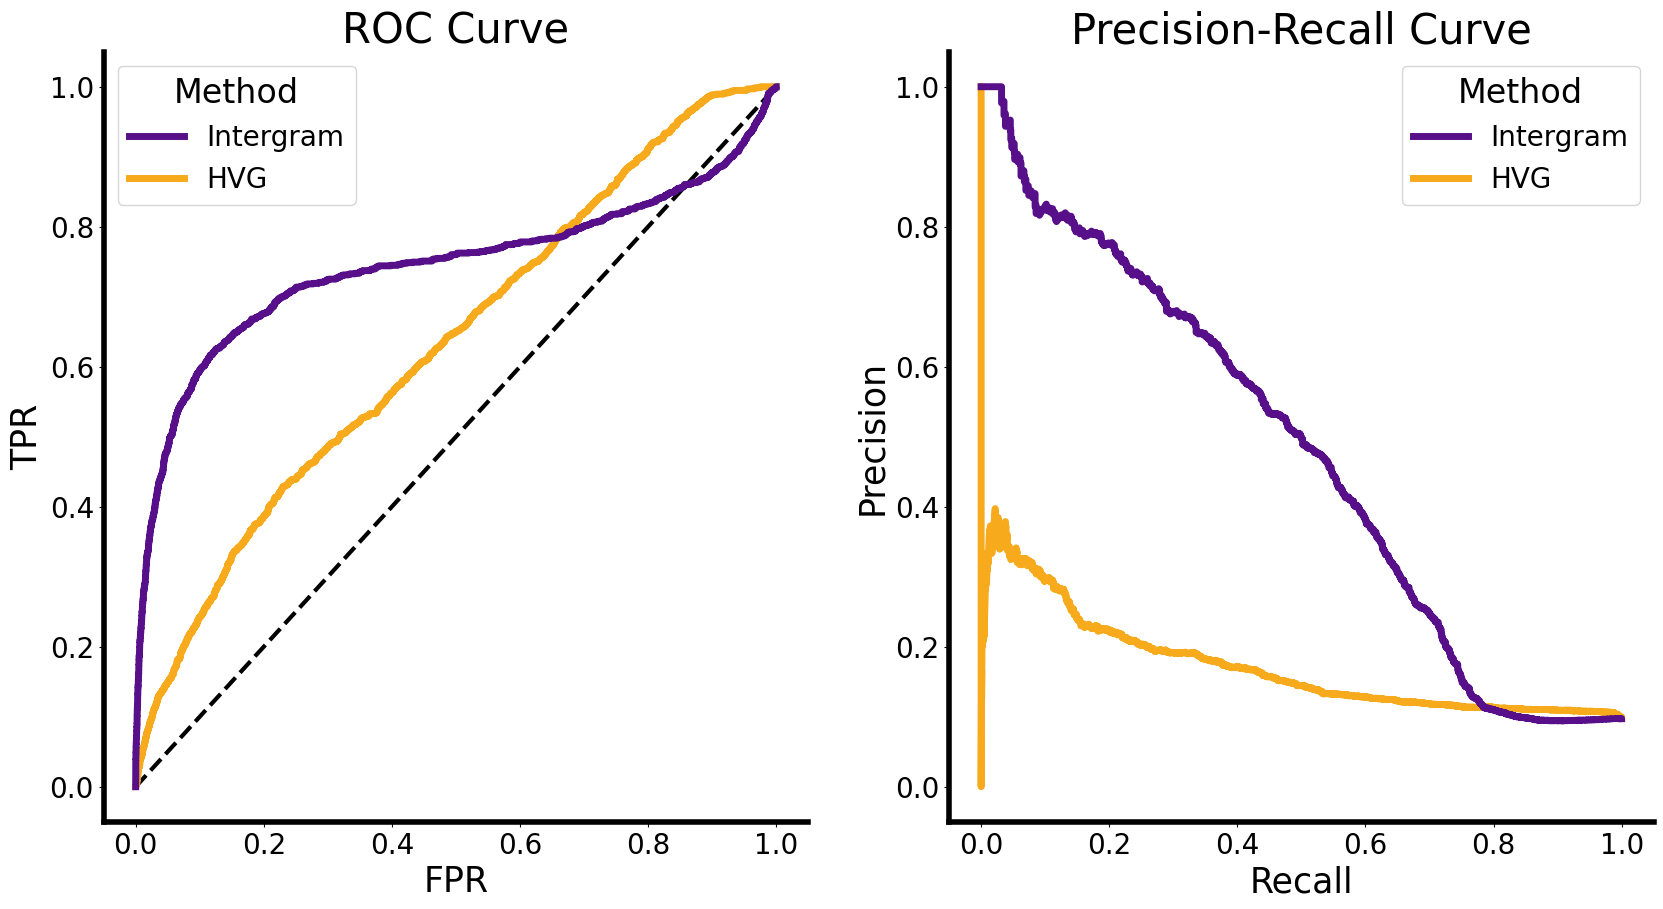

In [456]:
l_fs = 25
t_fs = 30

cmap = dict(Intergram = '#571089',
            HVG = '#f6aa1c',
           )

fig, ax = plt.subplots(1,2, figsize = (20,10))
for k,(name, x) in enumerate(zip (['Intergram','HVG'],[score_ig, score_hvg])):
    ax[0].plot(x[0],x[1], label = name, linewidth = 5, zorder = 1-k, color = cmap[name])

ax[0].set_ylabel('TPR',fontsize = l_fs)
ax[0].set_xlabel('FPR', fontsize = l_fs)
ax[0].plot([0,1],[0,1],linewidth = 3, color = 'black', linestyle='dashed',zorder = -1)

ax[0].legend(title="Method", loc="upper left",  fontsize=20, title_fontsize=24,)
ax[0].set_title('ROC Curve', fontsize = t_fs)


for k,(name, x) in enumerate(zip(['Intergram','HVG'],[pr_curve_ig, pr_curve_hvg])):
    ax[1].plot(x[1], x[0], label = name,linewidth = 5, zorder = 1 - k, color = cmap[name])
    

ax[1].legend(title="Method", loc="upper right",  fontsize=20, title_fontsize=24,)

ax[1].set_ylabel('Precision', fontsize = l_fs)
ax[1].set_xlabel('Recall', fontsize = l_fs)
ax[1].set_title('Precision-Recall Curve', fontsize = t_fs)

for axx in ax:
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)

    axx.spines['bottom'].set_linewidth(4)
    axx.spines['left'].set_linewidth(4)
    
    
    axx.tick_params(axis='x', labelsize=20, labelrotation=0, labelfontfamily = 'sans-serif')
    axx.tick_params(axis='y', labelsize=20, labelfontfamily = 'sans-serif')